In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

import IPython.display as display
from PIL import Image
import io

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from matplotlib.pyplot import imshow

import os

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
BasePath='/content/drive/My Drive/'

In [7]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def load_image_set(file):
    raw_image_dataset = tf.data.TFRecordDataset(file)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

#Función para cargar los archivos .tfrec desde un directorio del Drive
def list_tf_files_from_drive(path): 
  tf_directory = BasePath + os.sep + str(path)
  os.chdir(tf_directory)
  files = os.listdir()
  tffiles = list() 
  for file in files:
    if file.endswith(".tfrec"):
      tffiles.append(file)
  
  return tffiles

#Funcion para obtener las imagenes y su etiqueta desde los archivos .tfrec
def load_data(tffiles):
  X = []
  y = []

  for file in tffiles:
    records = load_image_set(file)
    for record in records:
      image_raw = record['image'].numpy()
      image = Image.open(io.BytesIO(image_raw))
      image = image.resize((256, 256))
        
      X.append(np.array(image))
      y.append(int(record['target'].numpy()))
    
  return X,y

# funcion para pasar de img a numpy array
def image_to_numpy_array(image_features):

    result = [] 
    image_raw = image_features['image'].numpy()

    image = Image.open(io.BytesIO(image_raw))
    image = image.resize((256, 256))
    
    return  np.array(image)

   
# trae arreglo de imagenes formato numpyArray
def getArray(file):
    images = []
    iset = load_image_set(file)
    k=0

    for seti in iset:
        images.append(image_to_numpy_array(seti))

    return images

# pasa de array a imagen jpg y guarda en la ruta
def imgToPath(path,images):
  count=0
  for i in images:
    im = Image.fromarray(i)
    im.save(str(path)+"positivos/images-"+str(count)+".jpg")
    count+=1

def arrayFromTFRECFiles(tffiles):
  result=[]
  for file in tffiles:
    records = load_image_set(file)
    for record in records:
      label=int(record['target'].numpy())
      if (label==1):
          result.append(image_to_numpy_array(record))
  return result



Se listan los archivos TFRecord disponibles en un directorio específico del Drive:

In [8]:
tffiles = list_tf_files_from_drive('Kaggle - Melanoma')
tffiles

['train00-2071.tfrec']

Se cargan las imágenes y sus etiquetas de los archivos TFRecord encontrados:

In [9]:
X, y = load_data(tffiles)

Se añade desbalanceo para los datos positivos

In [10]:
positivas=arrayFromTFRECFiles(tffiles)

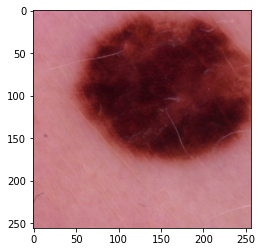

In [11]:
plt.imshow(positivas[1])

Variable de aumentacion

In [12]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Mostrar algunos ejemplo

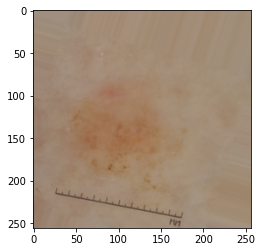

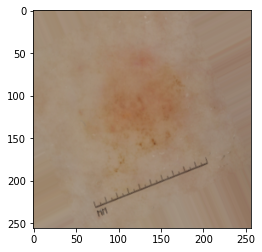

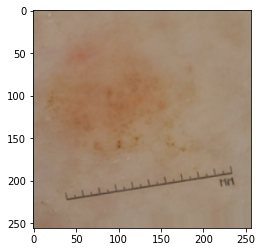

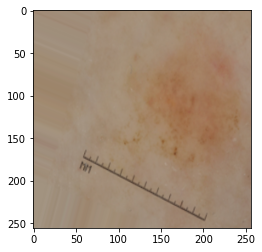

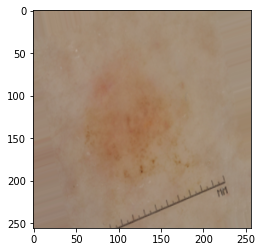

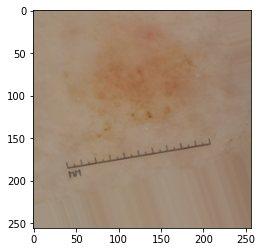

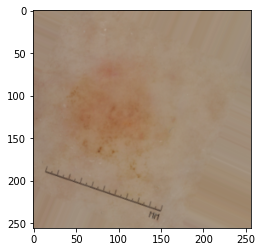

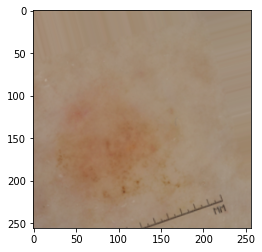

In [13]:
  x = img_to_array(positivas[0]) 
  x = x.reshape((1,) + x.shape)  
  i = 0

  for batch in datagen.flow(x, batch_size=1):
      i += 1
      if i > 8:
          break  # otherwise the generator would loop indefinitely
      plt.imshow(batch[0]/255) 
      plt.show()

Añadir imagenes positivas

In [14]:
for positivo in positivas:
  x = img_to_array(positivo) 
  x = x.reshape((1,) + x.shape)  
  i = 0

  for batch in datagen.flow(x, batch_size=1):
      i += 1
      if i > 20:
          break  # otherwise the generator would loop indefinitely
      # batch[0] = batch[0].flatten().reshape(256,256,3)
      X.append(batch[0]/255)
      y.append(1)
      # np.concatenate((X, batch[0]/255)) 
      




Se divide el conjunto de datos en los conjuntos de datos de entrenamiento y validación:

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=33)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_validation.shape)
print("y_validation: ", y_validation.shape)

X_train:  (2184, 256, 256, 3)
y_train:  (2184,)
X_validation:  (547, 256, 256, 3)
y_validation:  (547,)


Se define la siguiente función que permite crear la red neuronal convolucional:

In [16]:
def build_convolutional_model(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation):
  input = (256, 256, 3)
  output = 2
  kernel = (2, 2)

  conv_model = Sequential(name='hcl_{0}_if_{1}_hf_{2}_d_{3}_oa_{4}'.format(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation))
  
  conv_model.add(Conv2D(filters=input_filters, kernel_size=kernel, strides=(1,1), padding='same', input_shape=input, data_format='channels_last'))
  conv_model.add(Activation('relu'))
  conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  
  if hidden_conv_layers > 0:
    for i in range(hidden_conv_layers):
      conv_model.add(Conv2D(filters=hidden_filters, kernel_size=kernel, strides=(1,1), padding='valid'))
      conv_model.add(Activation('relu'))
      conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  conv_model.add(Flatten())    
  conv_model.add(Dense(256))
  conv_model.add(Activation('relu'))
  conv_model.add(Dropout(dropout))

  conv_model.add(Dense(output))
  conv_model.add(Activation(output_activation))

  conv_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
  return conv_model

Se instancia el modelo que se creará a partir de la función anterior:

In [17]:
model = KerasClassifier(build_fn=build_convolutional_model, epochs=25, verbose=1, shuffle=True)

Se definen los hiperparámetros que se van a iterar con la función `RandomizedSearchCV`:

In [18]:
param_grid = dict(hidden_conv_layers = [1, 2, 3],
                  input_filters = [16, 32, 64],
                  hidden_filters = [32, 64, 128],
                  dropout = [0.1, 0.3, 0.5, 0.7, 0.9],
                  output_activation = ['sigmoid', 'softmax'])

Se define la siguiente función de pérdida:

In [19]:
def loss_function(y_true, y_pred):
  return accuracy_score(y_true.argmax(axis=-1), y_pred)

In [20]:
score = make_scorer(loss_function, greater_is_better=True)

Se instancia la función `RandomizedSearchCV`

In [21]:
randomized_search = RandomizedSearchCV(model, param_grid, scoring=score, verbose=1, cv = 3, n_iter=3, random_state=20)

Se inicia la iteración de hiperparámetros:

In [22]:
randomized_search_grid = randomized_search.fit(X_train, tf.keras.utils.to_categorical(y_train, 2))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
1456/1456 [==============================] - 24s 17ms/step - loss: 8.9934 - accuracy: 0.3874
Epoch 2/25
1456/1456 [==============================] - 24s 16ms/step - loss: 10.1361 - accuracy: 0.3372
Epoch 3/25
1456/1456 [==============================] - 24s 16ms/step - loss: 10.4569 - accuracy: 0.3201
Epoch 4/25
1456/1456 [==============================] - 24s 16ms/step - loss: 8.0205 - accuracy: 0.4753
Epoch 5/25
1456/1456 [==============================] - 24s 16ms/step - loss: 9.0204 - accuracy: 0.4135
Epoch 6/25
1456/1456 [==============================] - 24s 16ms/step - loss: 8.1157 - accuracy: 0.4691
Epoch 7/25
1456/1456 [==============================] - 24s 16ms/step - loss: 4.7849 - accuracy: 0.6889
Epoch 8/25
1456/1456 [==============================] - 24s 16ms/step - loss: 4.3623 - accuracy: 0.7163
Epoch 9/25
1456/1456 [==============================] - 24s 16ms/step - loss: 3.9549 - accuracy: 0.7424
Epoch 10/25
1456/1456 [==============================] - 24s 1

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 76.7min finished


Epoch 1/25
2184/2184 [==============================] - 36s 16ms/step - loss: 23.5888 - accuracy: 0.8494
Epoch 2/25
2184/2184 [==============================] - 35s 16ms/step - loss: 2.6166 - accuracy: 0.9702
Epoch 3/25
2184/2184 [==============================] - 35s 16ms/step - loss: 0.5829 - accuracy: 0.9712
Epoch 4/25
2184/2184 [==============================] - 35s 16ms/step - loss: 0.2419 - accuracy: 0.9741
Epoch 5/25
2184/2184 [==============================] - 36s 16ms/step - loss: 0.1214 - accuracy: 0.9879
Epoch 6/25
2184/2184 [==============================] - 35s 16ms/step - loss: 0.1132 - accuracy: 0.9881
Epoch 7/25
2184/2184 [==============================] - 35s 16ms/step - loss: 0.1427 - accuracy: 0.9881
Epoch 8/25
2184/2184 [==============================] - 36s 16ms/step - loss: 0.1433 - accuracy: 0.9881
Epoch 9/25
2184/2184 [==============================] - 35s 16ms/step - loss: 0.1105 - accuracy: 0.9879
Epoch 10/25
2184/2184 [==============================] - 35s 16

Se obtiene el mejor modelo a partir de las iteraciones realizadas:

In [23]:
best_model = randomized_search_grid.best_estimator_
best_model.model.summary()

Model: "hcl_3_if_32_hf_128_d_0.3_oa_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 256, 256, 32)      416       
_________________________________________________________________
activation_55 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 127, 127, 128)     16512     
_________________________________________________________________
activation_56 (Activation)   (None, 127, 127, 128)     0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (N

Se obtienen las predicciones del para el conjunto de datos de validacion:

In [24]:
model_predictions = best_model.predict(X_validation)
model_predictions

547/547 [==============================] - 2s 3ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

Se obtienen los indices de las imágenes que fueron clasificados correctamente, y tambien aquellos donde el modelo se equivocó:

In [25]:
model_correct_indexes = np.nonzero(model_predictions == y_validation)[0]
model_incorrect_indexes = np.nonzero(model_predictions != y_validation)[0]

In [63]:
#Funcion que crea un nuevo conjunto de datos uniendo los conjuntos de las dos clases
def unify_classes(X_1):
  X = []

  for i in X_1:
    X.append(i)    
 

  return np.array(X)

In [64]:
newArray= unify_classes(X_validation)

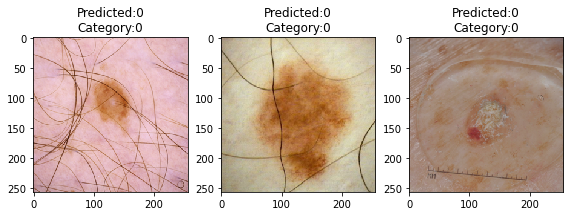

In [75]:
plt.figure(figsize=(8,8))

for i, correct in enumerate(model_correct_indexes[10:13]):
    plt.subplot(3,3,i+1)
    plt.imshow(newArray[correct]/255, cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[correct], y_validation[correct]))

plt.tight_layout()

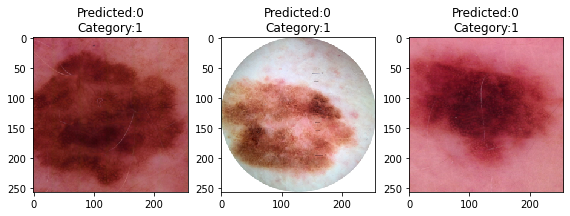

In [77]:
plt.figure(figsize=(8,8))

for i, incorrect in enumerate(model_incorrect_indexes[3:6]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_validation[incorrect]/255, cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[incorrect], y_validation[incorrect]))

plt.tight_layout()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_validation, model_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       418
           1       1.00      0.94      0.97       129

    accuracy                           0.99       547
   macro avg       0.99      0.97      0.98       547
weighted avg       0.99      0.99      0.99       547



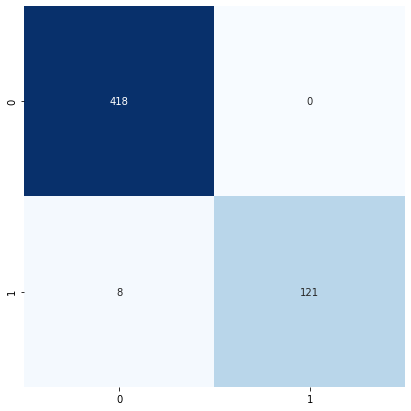

In [30]:
import seaborn as sns

cm = confusion_matrix(y_validation, model_predictions)

df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_validation)], columns = [i for i in np.unique(y_validation)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)